# find cluster predictive regions

In [1]:
import pandas as pd
import numpy as np

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

from collections import Counter, defaultdict
import pickle

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
#load top 1k masked probes
df_top_v1_prb_crc = pd.read_csv("./df_tcga_top1k_v1_probes_crc_pt2mask.csv")
df_top_v1_prb_crc.set_index("Unnamed: 0", inplace=True)
#print(df_top_v1_prb_crc.head())

#load consensus cluster labels
def create_clust_labels(file, data):
    df_clusters = pd.read_csv(file, header=None)
    cluster_dict = {}
    for i, row in df_clusters.iterrows():
        cluster_dict[row[0]] = row[1]
    clust_labels = [cluster_dict[sam] for sam in data.index]
    clust_labels = np.array(clust_labels).astype(str)
    print(Counter(clust_labels))
    return clust_labels

In [63]:
# plot feature importance for cluster generation
def select_features(data, cluster_labels, outfile=None, prev_feat_to_keep = None, nseeds=10):
    ''' generte an l1 regularized logreg that predicts cluster membership. 
    keep any features where the coeficient is not zero. 
    each coefficient can be interpreted as the expected change in log odds of cluster membership 
    for a one-unit increase in the percent methylation.
    #https://rpubs.com/OmaymaS/182726
    
    output features and an annotation of which feature is hypermethylated has a positive non-zero coeff. 
    In the end there should be N sets of features, each 
    characterizing a co-methylation group for each methylation subtype
    
    Return:
        signatures: a list of lists. each sublist a set of features whose hypermethylation defines
        one methylation subtype
    '''
    classes = set(clust_labels)
    print(f"N clusters: {len(classes)}")
    
    # MN LogReg regularized coefficients . . this works better than RF feature importances
    ## NOTE: this method outputs 80-100 features depending on random seed so repeat many times
    clf = LogisticRegression(penalty="l1", solver='liblinear') 
    coefs=[]
    for rep in range(nseeds):
        clf.fit(data, clust_labels)
        coefs.append(list(clf.coef_[0]))
    df_coefs = pd.DataFrame.from_records(coefs)
    #print(df_coefs.shape)
    df_coefs.columns = data.columns
    avg_coefs = df_coefs.apply(np.median, axis=0)
    
    signatures = []
    if len(classes)==2:
        plt.figure(figsize=(30,10))
        plt.scatter(x=range(len(data.columns)), y=np.sort(avg_coefs))
        cl1_feat_bool = [c > 0 for c in avg_coefs]
        print(f"cluster 1 features: {np.sum(np.array(cl1_feat_bool))}")
        cl2_feat_bool = [c < 0 for c in avg_coefs]
        print(f"cluster 2 features: {np.sum(np.array(cl2_feat_bool))}")
        signatures = [cl1_feat_bool, cl2_feat_bool]
    else:
        print("fix multinomial reporting")
        return
        plt.figure()
        for i, cluster in enumerate(classes):
            plt.subplot(len(classes), 1, i+1)
            plt.title(f"Class {cluster} vs. all")
            plt.scatter(x=range(len(data.columns)), y=np.sort(clf.coef_[i,:]))
            cl_feat_bool = [c > 0 for c in clf.coef_[i]]
            print(f"cluster {i} features: {np.sum(np.array(cl_feat_bool))}")
            signatures.append(cl_feat_bool)
    
    all_feat_to_keep = []
    clust_annot = []
    for i, sig in enumerate(signatures):
        all_feat_to_keep.extend(np.array(data.columns)[sig])
        clust_annot.extend(str(i)*len(np.array(data.columns)[sig])) 

    # from this we find that the majority of features are repeatedly selected with diff random seeds.
    if prev_feat_to_keep:
        print(f"repeat features: {np.sum(np.array([x in prev_feat_to_keep for x in all_feat_to_keep]))}")
    
    print(f"features to keep: {len(all_feat_to_keep)}")
    df_out = pd.DataFrame(zip(all_feat_to_keep, clust_annot))
    print(df_out.groupby(1).count())
    df_out.columns = ["marker","cluster"]
    if outfile:
        df_out.to_csv(f"./{outfile}", index=None)
    return df_out, all_feat_to_keep

Counter({'1': 213, '2': 148})
N clusters: 2
cluster 1 features: 24
cluster 2 features: 62
repeat features: 86
features to keep: 86
    0
1    
0  24
1  62


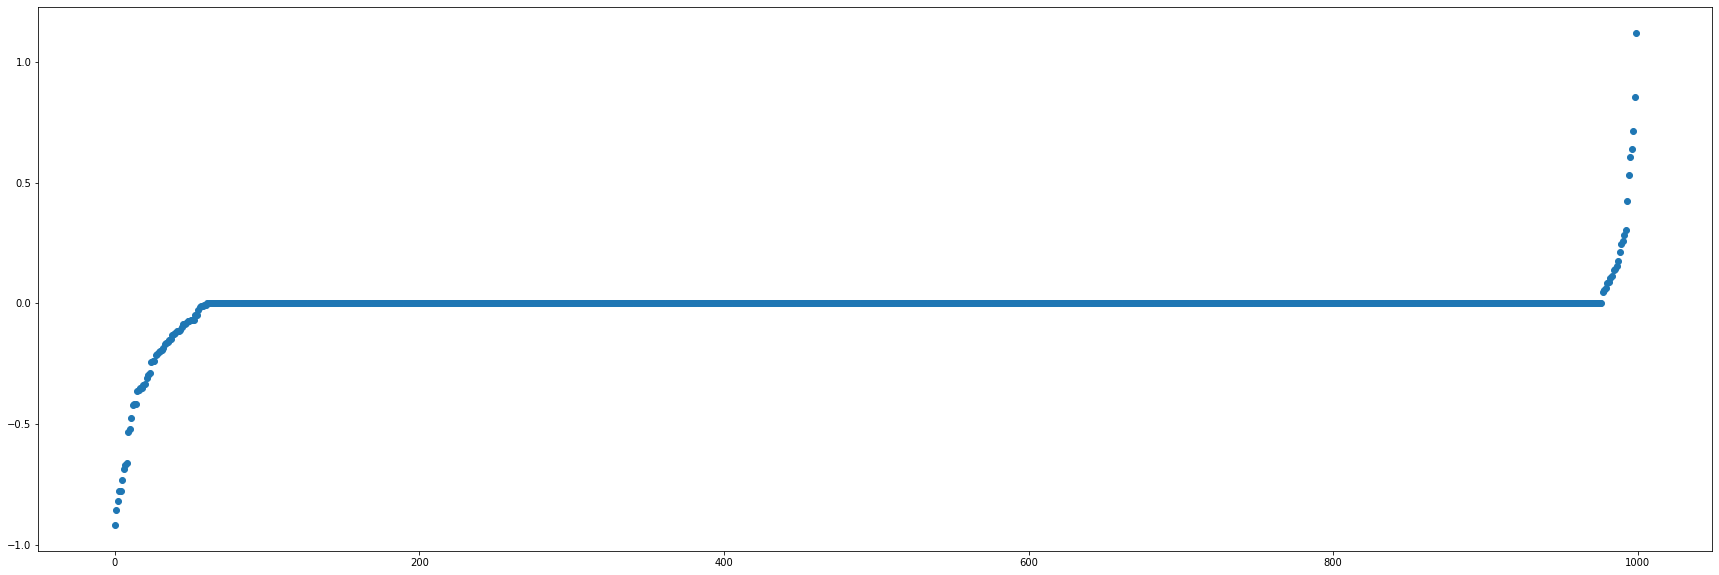

In [64]:
#df_top_v1_prb_crc.head()
clust_labels = create_clust_labels("./ConClust_kmeans_mask/ConClust_kmeans_mask.k=2.consensusClass.csv", df_top_v1_prb_crc)
df_feat_kmean_mask_k2, feat_to_keep = select_features(df_top_v1_prb_crc, clust_labels, 
                                                      outfile="./kmeans_mask_k2_probes.txt", 
                                                      prev_feat_to_keep=feat_to_keep,
                                                      nseeds=1000)

In [27]:
clust_labels = create_clust_labels("./ConClust_kmeans_mask/ConClust_kmeans_mask.k=4.consensusClass.csv", df_top_v1_prb_crc)
df_feat_kmean_mask_k4 = select_features(df_top_v1_prb_crc, clust_labels, outfile="./kmeans_mask_k4_probes.txt")


Counter({'4': 107, '3': 94, '1': 88, '2': 72})
N clusters: 4
fix multinomial reporting


/Users/billiegould/Desktop/research/env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/billiegould/Desktop/research/env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


# identify v1 panel regions containing selected tcga markers

In [58]:
# load v1 panel
v1_16K_regions = defaultdict(list)
with open("../methyl_panel_v1_target_twist.bed", "r") as fin:
    bed = pd.read_csv(fin, sep="\t", header=None)
    #print(bed.head())
    bed = bed.iloc[:,0:3]
    bed.columns = ['chrom', 'start', 'stop']
    for _, row in bed.iterrows():
        reg_name = str(row.chrom) + "_"+ str(row.start) + "_"+ str(row.stop)
        v1_16K_regions[row['chrom']].append((row['start'],row['stop'], reg_name))

print(v1_16K_regions["chr1"][0:5])

[(632108, 632228, 'chr1_632108_632228'), (935143, 935263, 'chr1_935143_935263'), (943939, 944095, 'chr1_943939_944095'), (963412, 963532, 'chr1_963412_963532'), (970916, 971158, 'chr1_970916_971158')]


In [59]:
# load 434 regions bed
# 434 Regions selected by early modeling and by lit search
from core.gcloud.file import opener
modeling_regions = defaultdict(list)
modeling_regions_names = []
with opener('gs://reference-datafiles/beds/freenome_v1_panel_manual_and_automated_per_region_hmf_definition_20190823.bed', 'r') as handle:
    expected_bed = pd.read_csv(handle, sep="\t", header=None)
    expected_bed.columns = ['chrom', 'start', 'stop']
    for _, row in expected_bed.iterrows():
        reg_name = str(row.chrom) + "_"+ str(row.start) + "_"+ str(row.stop)
        modeling_regions[row['chrom']].append((row['start'],row['stop'], reg_name))
        modeling_regions_names.append(reg_name)

print(modeling_regions["chr1"][0:4])
print(modeling_regions_names[0:4])

[(9652346, 9652712, 'chr1_9652346_9652712'), (12063181, 12063620, 'chr1_12063181_12063620'), (34163174, 34163579, 'chr1_34163174_34163579'), (34930048, 34930228, 'chr1_34930048_34930228')]
['chr1_9652346_9652712', 'chr1_12063181_12063620', 'chr1_34163174_34163579', 'chr1_34930048_34930228']


In [60]:
# load tcga probe metadata
df_probe_metadata = pickle.load(open("./df_keep_probes_metadata.pkl", "rb"))
df_probe_metadata.head()

,Chromosome,Start,End,Gene_Symbol,Gene_Type,Transcript_ID,Position_to_TSS,CGI_Coordinate,Feature_Type,in_v1_panel,in_v3_panel,v1_panel_region,v1_region
Composite Element REF,,,,,,,,,,,,,
cg00000029,chr16,53434200,53434201,RBL2;RBL2;RBL2,protein_coding;protein_coding;protein_coding,ENST00000262133.9;ENST00000544405.5;ENST000005...,-221;-1420;222,CGI:chr16:53434489-53435297,N_Shore,False,False,NA,NA
cg00000108,chr3,37417715,37417716,C3orf35;C3orf35;C3orf35;C3orf35;C3orf35;C3orf3...,lincRNA;lincRNA;lincRNA;lincRNA;lincRNA;lincRN...,ENST00000328376.8;ENST00000332506.6;ENST000004...,18552;18552;6505;31445;18143;447;18552;18552,CGI:chr3:37451927-37453047,.,False,False,NA,NA
cg00000109,chr3,172198247,172198248,FNDC3B;FNDC3B;FNDC3B;FNDC3B;FNDC3B;FNDC3B,protein_coding;protein_coding;protein_coding;p...,ENST00000336824.7;ENST00000415807.5;ENST000004...,157692;158618;151333;71272;158587;71273,CGI:chr3:172039703-172040934,.,False,False,NA,NA
cg00000165,chr1,90729117,90729118,.,.,.,.,CGI:chr1:90724932-90727247,S_Shore,False,False,NA,NA
cg00000236,chr8,42405776,42405777,VDAC3,protein_coding,ENST00000022615.7,13872,CGI:chr8:42410918-42411241,.,False,False,NA,NA


In [65]:
# load tcga marker list and metadata
#tcga_marker_list = []
#with open("./kmeans_mask_k2_probes.txt", "r") as fin:
#    for line in fin.readlines():
#        tcga_marker_list.append(line.strip())

df_feat_kmean_mask_k2 = pd.read_csv(open("./kmeans_mask_k2_probes.txt", "r"))
print(df_feat_kmean_mask_k2.head())
tcga_marker_list = list(df_feat_kmean_mask_k2.iloc[:,0])

       marker  cluster
0  cg03616722        0
1  cg06509223        0
2  cg24506221        0
3  cg20553577        0
4  cg16814680        0
['cg03616722', 'cg06509223', 'cg24506221', 'cg20553577', 'cg16814680', 'cg02293936', 'cg06266993', 'cg23564700', 'cg01873886', 'cg02246055', 'cg16570157', 'cg17736443', 'cg02159489', 'cg22681934', 'cg08154437', 'cg08248516', 'cg24008544', 'cg23332582', 'cg14159026', 'cg03483654', 'cg14255824', 'cg01939274', 'cg26522157', 'cg17603288', 'cg24371075', 'cg25830696', 'cg27438798', 'cg15825786', 'cg13021333', 'cg18745566', 'cg02907374', 'cg06368118', 'cg14081924', 'cg18136062', 'cg18800085', 'cg17038667', 'cg20893717', 'cg15454726', 'cg04100696', 'cg00366818', 'cg10748160', 'cg04689080', 'cg16485558', 'cg25373100', 'cg16882226', 'cg12376068', 'cg11514698', 'cg06466031', 'cg22761670', 'cg11964564', 'cg08042975', 'cg20115218', 'cg05817517', 'cg21309100', 'cg24933645', 'cg05099909', 'cg11258164', 'cg05293775', 'cg17512364', 'cg13643796', 'cg10957242', 'cg2532

In [84]:
# get regions containing tcga probes of interest
print(f"n_probes: {len(tcga_marker_list)}")
regions_of_interest = []
n_missing = 0
for prb, cluster in zip(tcga_marker_list, df_feat_kmean_mask_k2["cluster"]):
    pos = df_probe_metadata.loc[prb,"Start"]
    chrm = df_probe_metadata.loc[prb,"Chromosome"]
    found = False
    # if the probe is in a region in the 434 set, use that region
    for reg434 in modeling_regions[chrm]:
        if reg434[0] < pos-1 < reg434[1]:
            regions_of_interest.append([chrm, reg434[0], reg434[1], cluster])
            found = True
            break
    # else look for probe in 16K regions:
    if not found:
        for reg in v1_16K_regions[chrm]:
            # regstart < pos < regend
            if reg[0] < pos-1 < reg[1]:
                regions_of_interest.append([chrm, reg[0], reg[1], cluster])
                found = True
                break
    # else missing
    if not found:
        n_missing += 1

df_regions_of_interest = pd.DataFrame(regions_of_interest)
df_regions_of_interest.columns = ["chrm","start","end","cluster"]
df_regions_of_interest["name"] = df_regions_of_interest["chrm"] + ":" + df_regions_of_interest["start"].apply(str) + "-" + df_regions_of_interest["end"].apply(str)

#check for regions assigned to more than one cluster
for i, df in df_regions_of_interest.groupby("name"): 
    if len(df) > 1: 
        print(df)
        print("\n")
        
print(f"regions: {len(df_regions_of_interest)}")
df_regions_of_interest = df_regions_of_interest.drop_duplicates()
print(f"regions minus dups: {len(df_regions_of_interest)}")
print(f"n missing: {n_missing}")


n_probes: 86
    chrm     start       end  cluster                     name
5  chr17  48593145  48593993        0  chr17:48593145-48593993
6  chr17  48593145  48593993        0  chr17:48593145-48593993


    chrm     start       end  cluster                    name
76  chr2  31233763  31234264        1  chr2:31233763-31234264
79  chr2  31233763  31234264        1  chr2:31233763-31234264


    chrm      start        end  cluster                      name
70  chr6  132400991  132401785        1  chr6:132400991-132401785
71  chr6  132400991  132401785        1  chr6:132400991-132401785


regions: 85
regions minus dups: 82
n missing: 1


In [87]:
# create bed file for regions of interest
def make_bed_and_metadata(df_regions, out_pfx:str):
    list_of_region_dicts = []
    for i, row in df_regions.iterrows():
        chrm, start, stop, cluster = row[0], row[1], row[2], row[3]
        #chrm, start, stop, genes = region
        list_of_region_dicts.append( {"chrm":chrm,
                                      "start":start,
                                      "stop":stop,
                                      "cluster":cluster})
                                      #"genes":genes})

    thresh_dicts = [{f"thresh{n}": n} for n in range(3,34)]    
    calc_dicts = [ {"col1":"total_frags"}, {"col2":"methyl_frags"}]

    np.savez_compressed(f'./{out_pfx}_col_metadata.npz', np.array(list_of_region_dicts), np.array(thresh_dicts), np.array(calc_dicts))

    # write bed file
    #df_regions = pd.DataFrame(list_of_region_dicts)
    #print(df_regions.head())
    df_regions.to_csv(f"./{out_pfx}.bed", sep="\t", header=None, index=None)

    

In [88]:
# create feature metadata for regions of interest
make_bed_and_metadata(df_regions_of_interest, "tcga_k2_clust_regions_v2")

# gsutil cp tcga_k2_clust_regions.bed gs://reference-datafiles/beds/

In [176]:
# create feature using summarizer
'''
ftio create feature
name: hmfc_tcga_cluster_regions_k2
numpy_dtype: int64
shape: (78,31,2,)
column_metadata: /Users/billiegould/Desktop/my_repo/startup/TCGA_COAD_READ/tcga_k2_clust_regions_col_metadata.npz

ftio update feature
name: hmfc_tcga_cluster_regions_k2
version: 2
numpy_dtype: int64
shape: (85,31,2,)
column_metadata: /Users/billiegould/Desktop/my_repo/startup/TCGA_COAD_READ/tcga_k2_clust_regions_v2_col_metadata.npz

source ./create_tcga_hmfc_k2.sh


        0          1          2
0   chr13   22848547   22848667
1    chr1  109687545  109688046
2   chr13  110475647  110475815
3   chr17   43953039   43953159
4    chr4   13544188   13544834
..    ...        ...        ...
76   chr5   14405578   14405698
77   chr5   83471345   83472266
78  chr22   45009678   45010281
79   chr5  123088304  123088424
80   chr2  179861032  179861756

[78 rows x 3 columns]


# methyl cluster aware model

In [189]:
# import the hmfc model
# an example of a pineapple experiment running the methyl model:
# https://github.com/freenome/pineapple/blob/master/pineapple/experiments/dc1/methyl/methyl_poisson_spec_rrbs_mask.yaml

# transformers used to run the hmfc model
# https://github.com/freenome/pineapple/blob/master/pineapple/contrib/components/transformers/methyl/poisson_outlier.py

# how to use matrixfactory in pineapple
# https://github.com/freenome/research/blob/master/docs/data_access_tutorial.ipynb

# from here fly to Jupyter Hub !!! . . . . .

ModuleNotFoundError: No module named 'pineapple'